Here I try to understand what is doing the KDE function in faststats`.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.signal import convolve2d, convolve, gaussian
from matplotlib import pyplot as plt

In [2]:
xin = np.random.normal(size=1000)
gridsize = 200
weights = None
extents = None
adjust = 1.

In [3]:
# Variable check
x = np.squeeze(np.asarray(xin))

# Default extents are the extent of the data
if extents is None:
    xmin, xmax = x.min(), x.max()
else:
    xmin, xmax = map(float, extents)
    x = x[(x <= xmax) & (x >= xmin)]

n = x.size

In [4]:
if weights is None:
    # Default: Weight all points equally
    weights = np.ones(n)
else:
    weights = np.squeeze(np.asarray(weights))
    if weights.size != x.size:
        raise ValueError('Input weights must be an array of the same size as input x & y arrays!')

In [5]:
# Optimize gridsize ------------------------------------------------------
# Make grid and discretize the data and round it to the next power of 2
# to optimize with the fft usage
if gridsize is None:
    gridsize = np.max((len(x), 512.))
gridsize = 2 ** np.ceil(np.log2(gridsize))  # round to next power of 2

nx = int(gridsize)

In [63]:
# Make the sparse 2d-histogram -------------------------------------------
dx = (xmax - xmin) / (nx - 1) # (max - min) / 255

# Basically, this is just doing what np.digitize does with one less copy
# xyi contains the bins of each point as a 2d array [(xi,yi)]

# numpy.digitize: Return the indices of the bins to which each value in input array belongs.
xyi = x - xmin
xyi /= dx
xyi = np.floor(xyi)
xyi = np.vstack((xyi, np.zeros(n, dtype=int))) # (2, 1000) array where one row is all zeros.

# np.sort(xyi[0])

In [57]:
# Next, make a 2D histogram of x & y.
# Exploit a sparse coo_matrix avoiding np.histogram2d due to excessive
# memory usage with many points
grid = coo_matrix((weights, xyi), shape=(int(nx), 1)).toarray() # bin counts. length 256.

In [58]:
# Kernel Preliminary Calculations ---------------------------------------
# std_x = np.std(xyi[0]) # approx 36.9. What is the meaning of this?
# std_x ~ np.std(x) / dx
# Entonces el std_x a utilizar deberia ser `np.std(x) / dx` en vez del np.std(xyi[0])
# ... ahí es como que tiene mas sentido

std_x = np.std(x) / dx

# std_x is not the std of the original values, it is the standard deviations of the bin memberships.
# ....

# Scaling factor for bandwidth
scotts_factor = n ** (-1. / 5.) * adjust  # For n ** (-1. / (d + 4))

In [59]:
# Make the gaussian kernel ---------------------------------------------

# First, determine the bandwidth using Scott's rule
# (note that Silvermann's rule gives the # same value for 2d datasets)
kern_nx = int(np.round(scotts_factor * 2 * np.pi * std_x)) # 58. What does it mean?

# Then evaluate the gaussian function on the kernel grid
kernel = np.reshape(gaussian(kern_nx, scotts_factor * std_x), (kern_nx, 1)) # kernel has length `kern_nx`.

# kernel /= kernel.sum()

# scotts_factor is not technically the Scott's factor, it needs to be multiplied by `std_x`.

In [60]:
# ---- Produce the kernel density estimate --------------------------------

# Convolve the histogram with the gaussian kernel
# use symmetric padding to correct for data boundaries in the kde
npad = np.min((nx, 2 * kern_nx)) # npad is a heuristic
grid = np.vstack([grid[npad: 0: -1], grid, grid[nx: nx - npad: -1]]) # len(grid) > 512 or previously used power of two...
grid = convolve(grid, kernel, mode='same')[npad: npad + nx]

# If len(grid) is not a power of two because of the reflection... do we still have speed-up with the convolution?

In [61]:
# Normalization factor to divide result by so that units are in the same
# units as scipy.stats.kde.gaussian_kde's output.

norm_factor = 2 * np.pi * std_x * std_x * scotts_factor ** 2
norm_factor = n * dx * np.sqrt(norm_factor)

# Normalize the result
grid /= norm_factor

xgrid = np.linspace(xmin, xmax, num = len(grid))

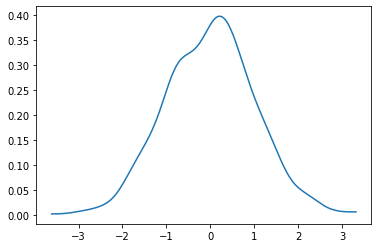

In [62]:
plt.plot(xgrid, grid)
plt.show()